The notebook is for postprocessing of shallow water model simulations run with different wind stress profiles.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dask
import dask.distributed
from dask.diagnostics import ProgressBar
from xgcm import Grid
import sys
%matplotlib inline

from dask.distributed import Client
from dask.distributed import LocalCluster
from dask_jobqueue import SLURMCluster


#cluster = LocalCluster()
#client = Client(cluster)
#client

In [2]:
import subprocess as sp
portdash = 30520
cluster = SLURMCluster(queue='analysis', cores=4, project='gfdl_o',memory="24GB", 
                       walltime="03:00:00",dashboard_address=f':{portdash}')
cluster.scale(2)
client = Client(cluster)
print(client)
print('http://localhost:'+str(portdash)+'/status')

<Client: 'tcp://140.208.147.173:32823' processes=0 threads=0, memory=0 B>
http://localhost:30520/status


In [3]:
# read prog.nc files for all runs (for 40-50 years simulation time. The simulations are in equilibrium state)
tau = ['Tau_001', 'Tau_003', 'Tau_005', 'Tau_01', 'Tau_03', 'Tau_05', 'Tau_1']
ppdir = "/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/Barotropic_Baroclinic/"

dataset_FW = []
dataset_VW = []

case = 'fplane'  # valid options are betaplane, fplane

t_st = 180 # starting time for averaging (use t_st = 180 for fplane as these runs used restart files from betaplane)

for i in range(0, len(tau)):
    if (case == 'betaplane'):
        file1 = ppdir+"2L_Fix_Width/"+tau[i]+"/prog_avg_50.nc"
        file2 = ppdir+"2L_Var_Width/"+tau[i]+"/prog_avg_50.nc"
    elif (case == 'fplane'):
        file1 = ppdir+"2L_fplane_Fix_Width/"+tau[i]+"/prog_avg_50.nc"
        file2 = ppdir+"2L_fplane_Var_Width/"+tau[i]+"/prog_avg_50.nc"
    else:
        sys.exit("case selection no valid")
        
    d = xr.open_dataset(file1, chunks = {'Time': 1}, decode_times=False) # chunks required
    dataset_FW.append(d)
    d = xr.open_dataset(file2, chunks = {'Time': 1}, decode_times=False) # for parallel compu.
    dataset_VW.append(d)
    
ds_FW = xr.concat(dataset_FW, dim='tau')
ds_VW = xr.concat(dataset_VW, dim='tau')

In [4]:
# Read topography and wind stress profile data
ta = ['1.0', '3.0', '5.0', '10.0', '30.0', '50.0', '100.0']

ppdir = "/nbhome/Hemant.Khatri/Topography-Eddy-MOM6/input-files/"

dataset_FW = []
dataset_VW = []

for i in range(0, len(ta)):
    d = xr.open_dataset(ppdir+"wind_stress_FW_tau_" + ta[i] + ".nc")
    dataset_FW.append(d)
    d = xr.open_dataset(ppdir+"wind_stress_VW_tau_" + ta[i] + ".nc")
    dataset_VW.append(d)

wind_FW = xr.concat(dataset_FW, dim='tau')
wind_VW = xr.concat(dataset_VW, dim='tau')

topo = xr.open_dataset(ppdir+"topography_2L.nc")
                       
ds_FW['taux'] = xr.DataArray(wind_FW['taux'].values,dims=['tau','yh','xh'])
ds_VW['taux'] = xr.DataArray(wind_VW['taux'].values,dims=['tau','yh','xh'])

ds_FW['depth'] = xr.DataArray(topo['depth'].values,dims=['yh','xh'])
ds_VW['depth'] = xr.DataArray(topo['depth'].values,dims=['yh','xh'])

In [5]:
# select time range
ds_FW = ds_FW.isel(Time = slice(t_st, len(ds_FW['Time']) -1))
ds_VW = ds_VW.isel(Time = slice(t_st, len(ds_VW['Time']) -1))

In [6]:
ds_FW

<xarray.Dataset>
Dimensions:     (Time: 184, nv: 2, tau: 7, xh: 400, xq: 400, yh: 800, yq: 800, zl: 2)
Coordinates:
  * xh          (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yh          (yh) float64 -1.598e+03 -1.594e+03 ... 1.594e+03 1.598e+03
  * yq          (yq) float64 -1.596e+03 -1.592e+03 ... 1.596e+03 1.6e+03
  * Time        (Time) float64 1.640e+04 1.642e+04 ... 1.822e+04 1.824e+04
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * zl          (zl) float64 1.027e+03 1.028e+03
Dimensions without coordinates: tau
Data variables:
    u           (tau, Time, zl, yh, xq) float32 dask.array<chunksize=(1, 1, 2, 800, 400), meta=np.ndarray>
    v           (tau, Time, zl, yq, xh) float32 dask.array<chunksize=(1, 1, 2, 800, 400), meta=np.ndarray>
    h           (tau, Time, zl, yh, xh) float32 dask.array<chunksize=(1, 1, 2, 800, 400), meta=np.ndarray>
    uh          (tau, Time, zl, yh, xq) flo

# Computations

In [7]:
# Grid create for computations
grid_FW = Grid(ds_FW, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X']);

grid_VW = Grid(ds_VW, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'}}, periodic=['X']);

In [9]:
# functions for computations

def TW_mean_eddy(ds, grid):
    
    hm = ds['h'].mean('Time')
    
    hum = grid.interp(hm, 'X', boundary='fill') # interpolate h on u, v points
    hvm = grid.interp(hm, 'Y', boundary='fill')
    
    um = ds['uh'].mean('Time') / hum # thickness-weighted mean velocities
    vm = ds['vh'].mean('Time') / hvm
    
    ue = ds['u'] - um; ve = ds['v'] - vm # thickness-weighted eddy velocities
    
    rho = ds['zl'].mean()
    
    hu = grid.interp(ds['h'], 'X', boundary='fill')
    hv = grid.interp(ds['h'], 'Y', boundary='fill')
    
    KE_m_zon = 0.5 * rho * (hum * um * um);  KE_m_mer = 0.5 * rho * (hvm * vm * vm)
    KE_e_zon = 0.5 * rho * (hu * ue * ue).mean('Time');  KE_e_mer = 0.5 * rho * (hv * ve * ve).mean('Time')
    
    ds1 = xr.Dataset()
    ds1['um'] = ds['u'].mean('Time'); ds1['vm'] = ds['v'].mean('Time')
    ds1['uhm'] = ds['uh'].mean('Time'); ds1['vhm'] = ds['vh'].mean('Time')
    ds1['hm'] = hm
    
    ds1['Zon_KE_mean'] = KE_m_zon; ds1['Mer_KE_mean'] = KE_m_mer; 
    ds1['Zon_KE_eddy'] = KE_e_zon; ds1['Mer_KE_eddy'] = KE_e_mer; 
    
    ds1['taux_bot'] = ds['taux_bot'].mean('Time')
    ds1['tauy_bot'] = ds['tauy_bot'].mean('Time')
    
    return ds1

In [10]:
save_pth = "/work/Hemant.Khatri/MOM6_idealised/SWM_Two_Layer/Barotropic_Baroclinic/Postprocessing/"
FW = TW_mean_eddy(ds_FW, grid_FW)
VW = TW_mean_eddy(ds_VW, grid_VW)

FW['taux'] = ds_FW['taux']
VW['taux'] = ds_VW['taux']
FW['depth'] = ds_FW['depth']
VW['depth'] = ds_VW['depth']

In [11]:
FW

<xarray.Dataset>
Dimensions:      (tau: 7, xh: 400, xq: 400, yh: 800, yq: 800, zl: 2)
Coordinates:
  * yh           (yh) float64 -1.598e+03 -1.594e+03 ... 1.594e+03 1.598e+03
  * xq           (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
  * zl           (zl) float64 1.027e+03 1.028e+03
  * xh           (xh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq           (yq) float64 -1.596e+03 -1.592e+03 ... 1.596e+03 1.6e+03
Dimensions without coordinates: tau
Data variables:
    um           (tau, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 800, 400), meta=np.ndarray>
    vm           (tau, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 800, 400), meta=np.ndarray>
    uhm          (tau, zl, yh, xq) float32 dask.array<chunksize=(1, 2, 800, 400), meta=np.ndarray>
    vhm          (tau, zl, yq, xh) float32 dask.array<chunksize=(1, 2, 800, 400), meta=np.ndarray>
    hm           (tau, zl, yh, xh) float32 dask.array<chunksize=(1, 2, 800, 400), meta=np.nd

In [12]:
FW.to_netcdf(save_pth + case + '_FW_mean.nc')
VW.to_netcdf(save_pth + case + '_VW_mean.nc')

# Plots

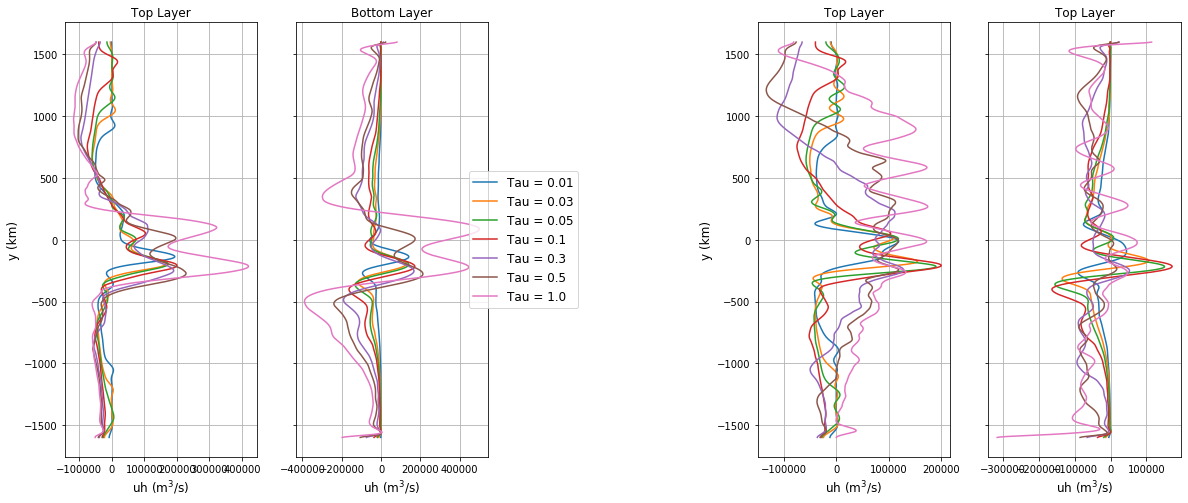

In [16]:
# Plot zonal transport 
leg = ['0.01', '0.03', '0.05', '0.1', '0.3', '0.5', '1.0']

grid_plot = plt.GridSpec(1, 5, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[20,8])

for i in range(0,2):
    ax = fig.add_subplot(grid_plot[0, i])
    ax.plot(uh_FW.isel(zl=i).transpose(), ds_FW['yh'])
    ax.set_xlabel('uh (m$^3$/s)', fontsize=12)
    ax.grid()
    if(i==0):
        ax.set_ylabel('y (km)',fontsize=12)
        ax.set_title('Top Layer',fontsize=12)
    else:
        ax.set_yticklabels([])
        ax.set_title('Bottom Layer',fontsize=12)
        ax.legend([ 'Tau = ' + str(lag) for lag in leg], loc='center right', 
                  bbox_to_anchor=(1.5, 0.5), fontsize=12)
    
    ax = fig.add_subplot(grid_plot[0, 3+i])
    ax.plot(uh_VW.isel(zl=i).transpose(), ds_VW['yh'])
    ax.set_xlabel('uh (m$^3$/s)', fontsize=12)
    ax.grid()
    if(i==0):
        ax.set_ylabel('y (km)',fontsize=12)
        ax.set_title('Top Layer',fontsize=12)
    else:
        ax.set_yticklabels([])
        ax.set_title('Bottom Layer',fontsize=12)

In [12]:
ds_FW['uh']

<xarray.DataArray 'uh' (tau: 7, Time: 365, zl: 2, yh: 800, xq: 400)>
dask.array<concatenate, shape=(7, 365, 2, 800, 400), dtype=float32, chunksize=(1, 10, 2, 800, 400), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -1.598e+03 -1.594e+03 ... 1.594e+03 1.598e+03
  * zl       (zl) float64 1.027e+03 1.028e+03
  * Time     (Time) float64 1.460e+04 1.462e+04 ... 1.824e+04 1.824e+04
  * xq       (xq) float64 4.0 8.0 12.0 16.0 ... 1.592e+03 1.596e+03 1.6e+03
Dimensions without coordinates: tau
Attributes:
    long_name:      Zonal Thickness Flux
    units:          m3 s-1
    cell_methods:   zl:sum yh:sum xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

In [13]:
ds_FW.close()
ds_VW.close()
client.close()
cluster.close()

In [14]:
client.close()
cluster.close()